# Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Images

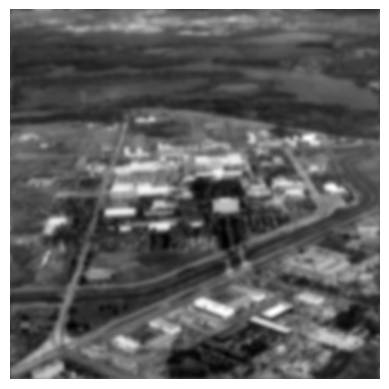

In [2]:
img1 = cv2.imread('Fig0525(b)(aerial_view_turb_c_0pt0025).tif', cv2.IMREAD_GRAYSCALE)
# img1 = cv2.imread('Fig5.25.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()

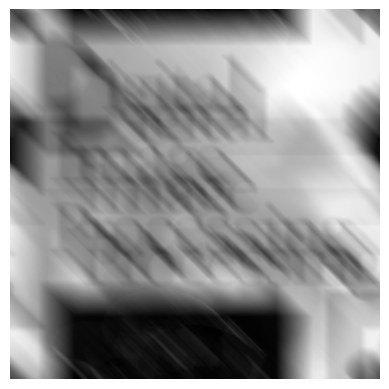

In [3]:
img2 = cv2.imread('book-cover-blurred.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.show()

# Useful functions

In [4]:
def get_magnitude(image):
    return np.log(1 + np.abs(image))

def degradation_func1(image, k=0.0025):
    M, N = image.shape
    u, v = np.meshgrid(np.arange(M), np.arange(N))
    return np.exp(-k * (((u - M//2)**2 + (v - N//2)**2)**(5/6)))

###TODO###
def degradation_func2(image, T=1, a=0.1, b=0.1):
    M, N = image.shape
    u, v = np.meshgrid(np.linspace(-M//2, M//2, M), np.linspace(-N//2, N//2, N))
    return (T / (np.pi * (u * a + v * b))) * np.sin(np.pi * (u * a + v * b)) * np.exp(-1j * np.pi * (u * a + v * b))
    # return np.sinc(u*a + v*b) * np.exp(-1j * np.pi * (u*a + v*b))

def LPFilter(image, radius):
    M, N = image.shape
    u, v = np.meshgrid(np.arange(M), np.arange(N))
    D = ((u - M//2)**2 + (v - N//2)**2)**0.5
    kernel = np.zeros(image.shape[:2], np.float32)
    kernel[D <= radius] = 1
    return kernel

def inverse_filtering(image, H, D_0=0, mode='normal'):
    """
    Inverse Filtering

    Args:
        image: Input image
        H: Degradation function
        figsize: Output size of the result image
        D_0: Low-pass filter radius (default=0)
        mode: output mode (default=normal)
    """
    
    # FFT
    fft = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft)  # Shift the zero frequency component to the center

    if D_0 == 0:
        fft_shifted_filtered = fft_shifted / H
    else:
        lpf = LPFilter(fft_shifted, radius=D_0)
        fft_shifted_filtered = fft_shifted / H * lpf
    
    # IDFT
    ifft_unshift = np.fft.ifftshift(fft_shifted_filtered)
    ifft = np.fft.ifft2(ifft_unshift)

    rebuilded_image = np.uint8(cv2.normalize(np.abs(ifft), None, 0, 255, cv2.NORM_MINMAX))

    if mode == 'normal':
        plt.figure(figsize=(10, 10))
        plt.subplot(2, 2, 1), plt.imshow(image, cmap='gray')
        plt.title('Original Image'), plt.axis('off')
        plt.subplot(2, 2, 2), plt.imshow(get_magnitude(fft_shifted), cmap='gray')
        plt.title('Fourier Spectrum'), plt.axis('off')
        plt.subplot(2, 2, 3), plt.imshow(get_magnitude(H), cmap='gray')
        plt.title('Degradation Function'), plt.axis('off')
        plt.subplot(2, 2, 4), plt.imshow(rebuilded_image, cmap='gray')
        plt.title(f'Reconstruct Image (D_0={D_0})'), plt.axis('off')
        plt.show()
        
    elif mode == 'format':
        D_0_values = [image.shape[0], 40, 70, 85]
        
        plt.figure(figsize=(12, 12))
        plt.subplot(1, 3, 1), plt.imshow(image, cmap='gray')
        plt.title('Original Image'), plt.axis('off')
        plt.subplot(1, 3, 2), plt.imshow(get_magnitude(fft_shifted), cmap='gray')
        plt.title('Fourier Spectrum'), plt.axis('off')
        plt.subplot(1, 3, 3), plt.imshow(get_magnitude(H), cmap='gray')
        plt.title('Degradation Function'), plt.axis('off')
        plt.show()
        
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        for i, D_0 in enumerate(D_0_values):
            if D_0 == 0:
                fft_shifted_filtered = fft_shifted / H
            else:
                lpf = LPFilter(fft_shifted, radius=D_0)
                fft_shifted_filtered = fft_shifted / H * lpf
            
            ifft_unshift = np.fft.ifftshift(fft_shifted_filtered)
            ifft = np.fft.ifft2(ifft_unshift)
            rebuilded_image = np.uint8(cv2.normalize(np.abs(ifft), None, 0, 255, cv2.NORM_MINMAX))
            
            axs[i // 2, i % 2].imshow(rebuilded_image, cmap='gray')
            if i == 0:
                axs[i // 2, i % 2].set_title(f'Reconstruct Image (w/o limit)')
            else:
                axs[i // 2, i % 2].set_title(f'Reconstruct Image (D_0={D_0})')
            axs[i // 2, i % 2].axis('off')
        
        plt.show()

def wiener_filtering(image, H, K, show_result=True):
    
    # FFT
    fft = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft)

    fft_shifted_filtered = (1 / np.abs(H)) * ((np.abs(H))**2 / ((np.abs(H))**2 + K)) * fft_shifted

    # IDFT
    ifft_unshift = np.fft.ifftshift(fft_shifted_filtered)
    ifft = np.fft.ifft2(ifft_unshift)

    rebuilded_image = np.uint8(cv2.normalize(np.abs(ifft), None, 0, 255, cv2.NORM_MINMAX))

    if show_result:
        plt.figure(figsize=(10, 10))
        plt.subplot(2, 2, 1), plt.imshow(image, cmap='gray')
        plt.title('Original Image'), plt.axis('off')
        plt.subplot(2, 2, 2), plt.imshow(get_magnitude(fft_shifted), cmap='gray')
        plt.title('Fourier Spectrum'), plt.axis('off')
        plt.subplot(2, 2, 3), plt.imshow(get_magnitude(H), cmap='gray')
        plt.title('Degradation Function'), plt.axis('off')
        plt.subplot(2, 2, 4), plt.imshow(rebuilded_image, cmap='gray')
        plt.title('Reconstruct Image'), plt.axis('off')
        plt.show()
    else:
        plt.imshow(rebuilded_image, cmap='gray')
        plt.axis('off')
        plt.show()

## 1. Fig5.25.jpg

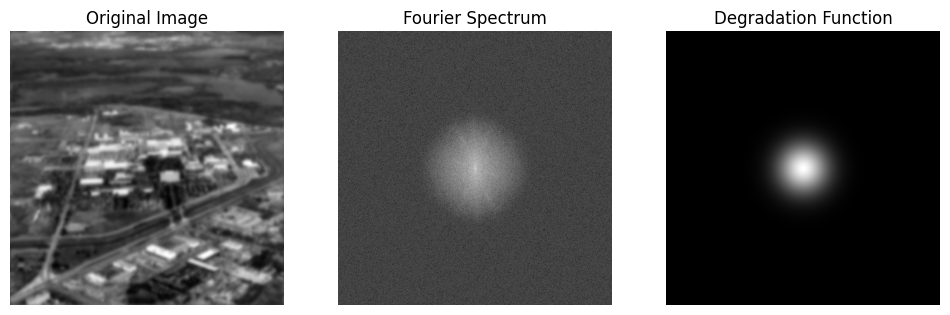

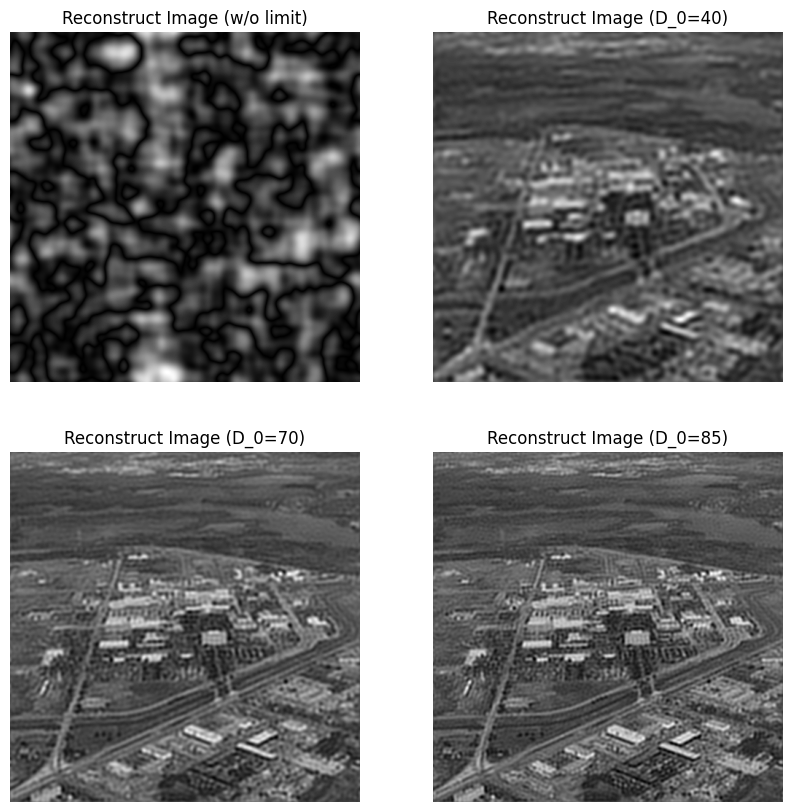

In [5]:
inverse_filtering(img1, H=degradation_func1(img1), mode='format')

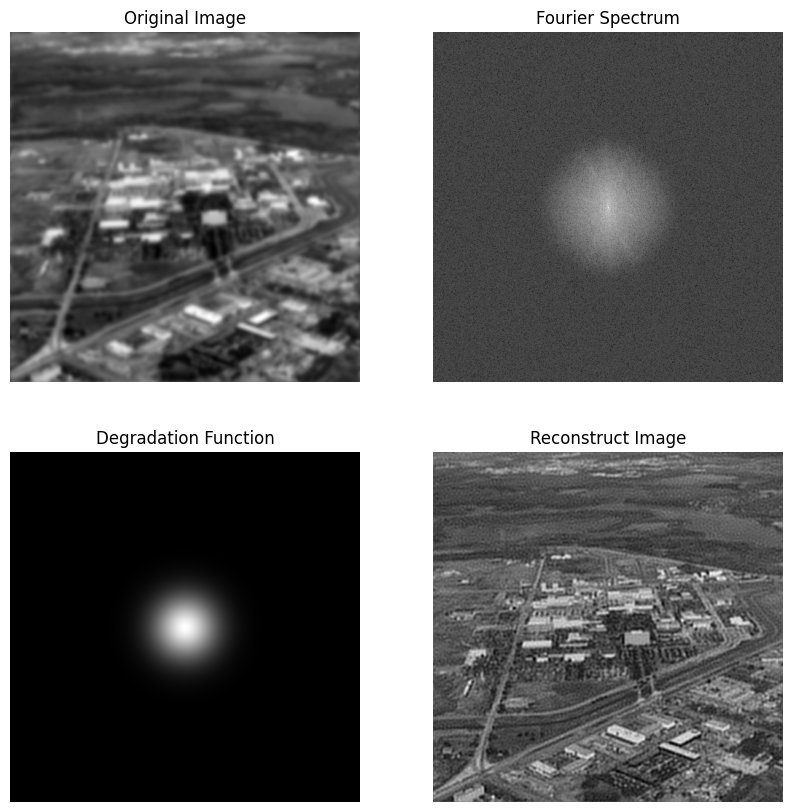

In [18]:
wiener_filtering(img1, H=degradation_func1(img1), K=5e-5)

## 2.book-cover-blurred.tif

C:\Users\vince\AppData\Local\Temp\ipykernel_23332\2387705694.py:13: RuntimeWarning: divide by zero encountered in divide
  return (T / (np.pi * (u * a + v * b))) * np.sin(np.pi * (u * a + v * b)) * np.exp(-1j * np.pi * (u * a + v * b))
C:\Users\vince\AppData\Local\Temp\ipykernel_23332\2387705694.py:13: RuntimeWarning: invalid value encountered in multiply
  return (T / (np.pi * (u * a + v * b))) * np.sin(np.pi * (u * a + v * b)) * np.exp(-1j * np.pi * (u * a + v * b))
C:\Users\vince\AppData\Local\Temp\ipykernel_23332\2387705694.py:41: RuntimeWarning: invalid value encountered in divide
  fft_shifted_filtered = fft_shifted / H
C:\Users\vince\AppData\Local\Temp\ipykernel_23332\2387705694.py:50: RuntimeWarning: invalid value encountered in cast
  rebuilded_image = np.uint8(cv2.normalize(np.abs(ifft), None, 0, 255, cv2.NORM_MINMAX))


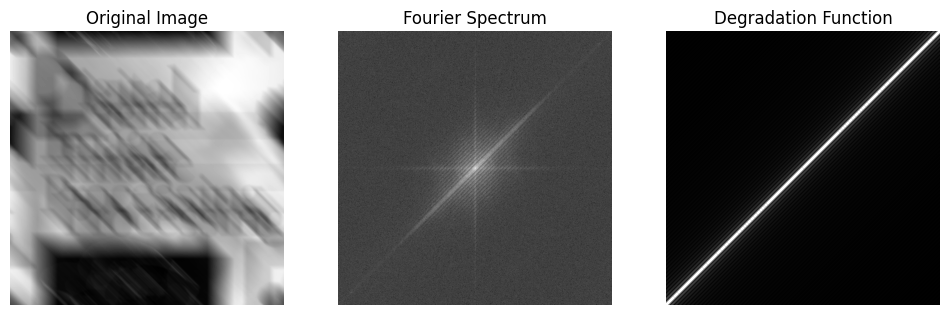

C:\Users\vince\AppData\Local\Temp\ipykernel_23332\2387705694.py:83: RuntimeWarning: invalid value encountered in divide
  fft_shifted_filtered = fft_shifted / H * lpf
C:\Users\vince\AppData\Local\Temp\ipykernel_23332\2387705694.py:87: RuntimeWarning: invalid value encountered in cast
  rebuilded_image = np.uint8(cv2.normalize(np.abs(ifft), None, 0, 255, cv2.NORM_MINMAX))


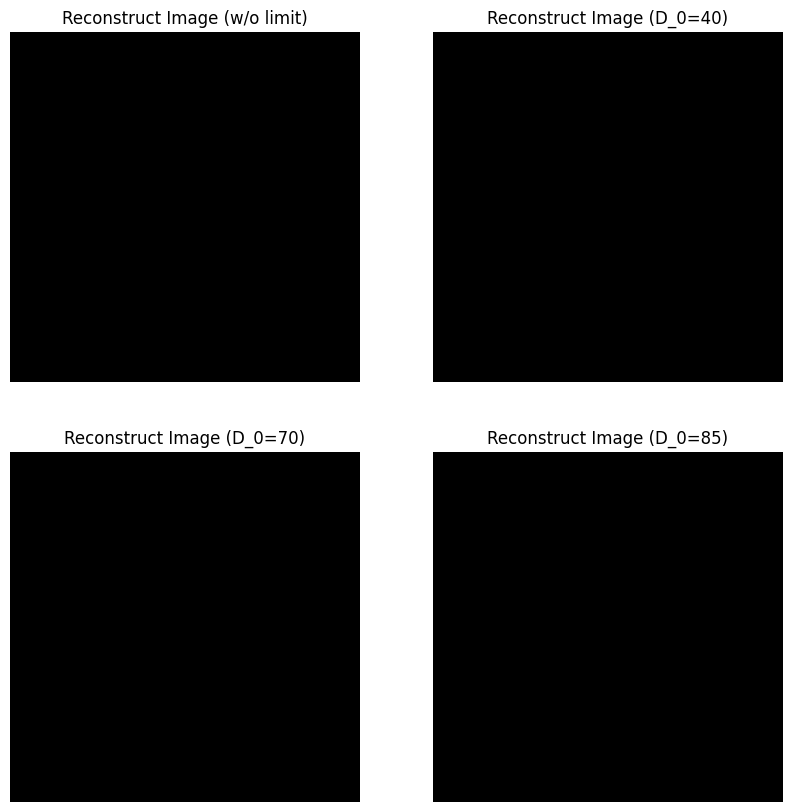

In [7]:
inverse_filtering(img2, H=degradation_func2(img2), mode='format')